In [1]:
import numpy as np
import pandas as pd


# Loading MNIST dataset including both image and audio data
train_images = np.load('x_train_wr.npy')
train_audio = np.load('x_train_sp.npy')
y_train_df = pd.read_csv('y_train.csv')
train_labels = y_train_df['label'].values

test_images = np.load('x_test_wr.npy')
test_audio = np.load('x_test_sp.npy')

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into train and validation sets for both image and audio data
x_images_train, x_images_val, x_audio_train, x_audio_val, y_train, y_val = train_test_split(train_images, train_audio, train_labels, test_size=0.2, random_state=42)

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Cr

class CustomImageDataset(Dataset):
    def __init__(self, x_train, y_train=None, transform=None):
        self.x = x_train
        self.y = y_train
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = self.x[idx].reshape(28, 28)  # Reshape to 28x28
        label = self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label


# Define data loader
def create_image_data_loader(x_train, x_images_val, y_train, y_val, batch_size):
    # Load training data
    train_dataset = CustomImageDataset(x_train, y_train)
    # Load validation data
    val_dataset = CustomImageDataset(x_images_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    # Create validation data loader
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader


# Create image train and validation data loaders
Image_train_loader, Image_val_loader = create_image_data_loader(x_images_train, x_images_val, y_train, y_val, batch_size=64)



class CustomAudioDataset(Dataset):
    def __init__(self, x_train, y_train=None, transform=None):
        self.x = x_train
        self.y = y_train
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        sample = self.x[idx]  # No need to reshape for audio data
        label = self.y[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

def create_audio_data_loader(x_audio_train, x_audio_val, y_train, y_val, batch_size):
    # Load training data
    train_dataset = CustomAudioDataset(x_audio_train, y_train)
    # Load validation data
    val_dataset = CustomAudioDataset(x_audio_val, y_val)

    # Create training data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    # Create validation data loader
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

# Create audio train and validation data loaders
Audio_train_loader, Audio_val_loader = create_audio_data_loader(x_audio_train, x_audio_val, y_train, y_val, batch_size=64)

In [4]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define CNN model with configurable hyperparameters - Image Encoder
class CNN(nn.Module):
    def __init__(self, filter_size=5, num_filters=32, activation='relu'):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters, kernel_size=filter_size)
        self.conv2 = nn.Conv2d(num_filters, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.activation = nn.ReLU()


    def forward(self, x):
        x = self.activation(F.max_pool2d(self.conv1(x.float()), 2))
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 64 * 5 * 5)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Define ANN model with configurable hyperparameters - Audio Encoder
class ANN(nn.Module):
    def __init__(self, input_size=507, hidden_size=128, num_classes=10, activation='relu', dropout=0.5):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class FusionModel(nn.Module):
    def __init__(self, cnn_model, ann_model):
        super(FusionModel, self).__init__()
        self.cnn_model = cnn_model
        self.ann_model = ann_model
        self.fc_fusion = nn.Linear(10 + 10, 10)  # Fusion layer with input size 20 and output size 10

    def forward(self, image, audio):
        # Forward pass through CNN model
        cnn_output = self.cnn_model(image.unsqueeze(1).float())
        
        # Forward pass through ANN model
        ann_output = self.ann_model(audio.float())
        
        # Concatenate the outputs from both models
        fused_output = torch.cat((cnn_output, ann_output), dim=1)
        
        # Pass the concatenated features through fusion layer
        fused_output = self.fc_fusion(fused_output)
        
        return fused_output


In [7]:
def train_model(model, image_loader, audio_loader, optimizer, criterion, epochs=10):
    model.train()  # Set the model to training mode
    
    for epoch in range(epochs):
        image_embeddings = []
        audio_embeddings = []
        labels = []
        running_loss = 0.0
        for (image_data, image_labels), (audio_data, audio_labels) in zip(image_loader, audio_loader):
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(image_data, audio_data)
            loss = criterion(outputs, image_labels)  # Using image_labels or audio_labels, both are of same length

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # Extract embeddings
            with torch.no_grad():
                image_embeddings.append(model.cnn_model(image_data.unsqueeze(1).float()))
                audio_embeddings.append(model.ann_model(audio_data.float()))
                labels.append(image_labels)
        

        # Print average loss for the epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(image_loader)}")
        # Convert lists to numpy arrays
        image_embeddings = np.concatenate(image_embeddings)
        audio_embeddings = np.concatenate(audio_embeddings)
        labels = np.concatenate(labels)

    return image_embeddings, audio_embeddings, labels


In [8]:
def validate_model(model, image_loader, audio_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    #total_loss = 0.0
    #total_samples = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for (image_data, image_labels), (audio_data, audio_labels) in zip(image_loader, audio_loader):
            # Forward pass
            outputs = model(image_data, audio_data)
            _, predicted = torch.max(outputs.data, 1)
            total += image_labels.size(0)
            correct += (predicted == image_labels).sum().item()


    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy}")
    return total, accuracy 


In [10]:
filter_sizes = [3, 5]
num_filters_list = [32, 64]
lr = [ 0.05, 0.01, 0.005, 0.001]

best_accuracy = 0
best_model = None
best_hyperparameters = {}
best_image_embeddings =[]
best_audio_embeddings = []
best_labels = []
all_models = []  # List to store all models

# Iterate over all combinations of hyperparameters
for filter_size in filter_sizes:
    for num_filters in num_filters_list:
        for lrt in lr:
            print(f'\nExperimenting with filter_size={filter_size}, num_filters={num_filters}, lr={lrt}')
            # Instantiate the CNN and ANN models
            cnn_model = CNN(filter_size=5, num_filters=64, activation='relu')
            ann_model = ANN(input_size=507, hidden_size=128, num_classes=10)

            # Instantiate the Fusion model
            fusion_model = FusionModel(cnn_model, ann_model)
            
            # Define optimizer and loss function
            optimizer = optim.Adam(fusion_model.parameters(), lr=0.001)
            criterion = nn.CrossEntropyLoss()
            
            image_embeddings, audio_embeddings, labels = train_model(fusion_model, Image_train_loader, Audio_train_loader, optimizer, criterion)
            # Get accuracy on validation set
            # Set the model to evaluation mode
            fusion_model.eval()

            # Call the validate_model function
            validation_loss = validate_model(fusion_model, Image_val_loader, Audio_val_loader, criterion)
            _, accuracy = validate_model(fusion_model, Image_val_loader, Audio_val_loader, criterion)

            # Save the model 
            # Added this saved models to the submission, in the folder trained_models
            model_name = f'model_filter_{filter_size}_num_filters_{num_filters}_lr_{lrt}.pt'
            torch.save(fusion_model.state_dict(), model_name)
            all_models.append((model_name, accuracy))  # Append model name and accuracy to the list
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model = fusion_model
                best_image_embeddings = image_embeddings
                best_audio_embeddings = audio_embeddings
                best_labels = labels
                #best_image_labels = image_labels
                #best_audio_labels = audio_labels
                best_hyperparameters = {'filter_size': filter_size, 'num_filters': num_filters, 'lr': lrt}

print(f'\nBest hyperparameters: {best_hyperparameters}')
print(f'Best accuracy on validation set: {best_accuracy:.2f}%')

# Print the list of model names and their corresponding accuracies
for model_name, accuracy in all_models:
    print(f"Model: {model_name}, Accuracy: {accuracy:.2f}%")


Experimenting with filter_size=3, num_filters=32, lr=0.05
Epoch [1/10], Loss: 0.24043407997178534
Epoch [2/10], Loss: 0.057839067669585346
Epoch [3/10], Loss: 0.03856787492272754
Epoch [4/10], Loss: 0.02857878956439284
Epoch [5/10], Loss: 0.022269967124661585
Epoch [6/10], Loss: 0.017591106842204076
Epoch [7/10], Loss: 0.014253506205750454
Epoch [8/10], Loss: 0.012763660966433235
Epoch [9/10], Loss: 0.011859967877263747
Epoch [10/10], Loss: 0.00793941312137728
Validation Accuracy: 98.8
Validation Accuracy: 98.8

Experimenting with filter_size=3, num_filters=32, lr=0.01
Epoch [1/10], Loss: 0.24780265502010781
Epoch [2/10], Loss: 0.05804619038756937
Epoch [3/10], Loss: 0.039090452898992226
Epoch [4/10], Loss: 0.028374465926278694
Epoch [5/10], Loss: 0.02156743463637152
Epoch [6/10], Loss: 0.01815173213838716
Epoch [7/10], Loss: 0.01547154059249927
Epoch [8/10], Loss: 0.01262285590035996
Epoch [9/10], Loss: 0.009446967525277614
Epoch [10/10], Loss: 0.009823629820607494
Validation Accurac

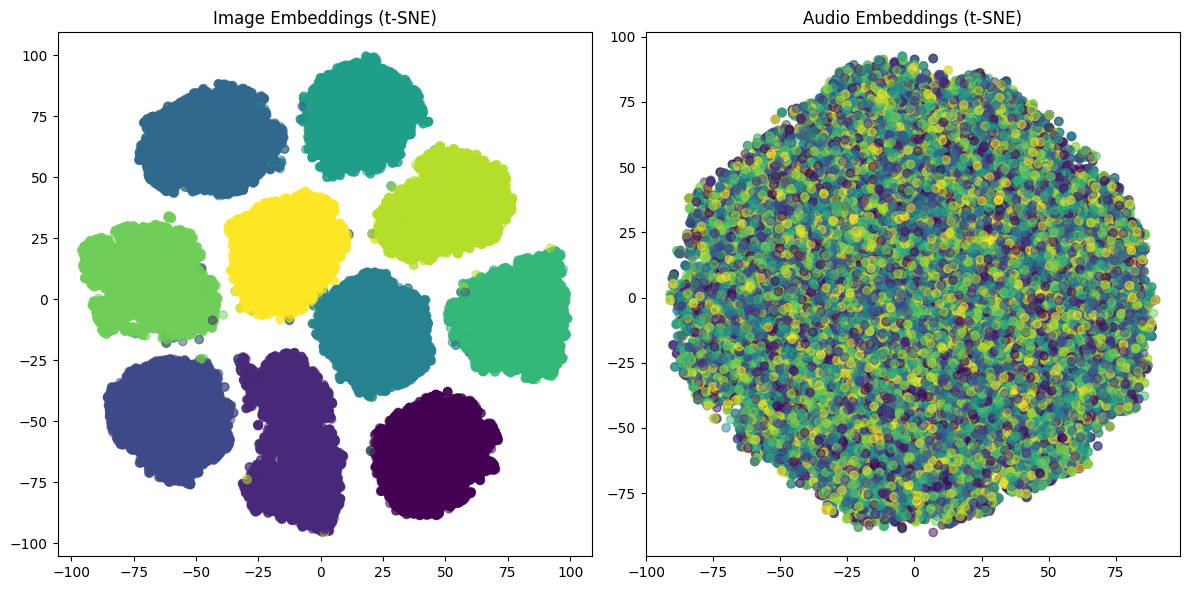

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Dimensionality reduction using t-SNE
image_tsne = TSNE(n_components=2).fit_transform(best_image_embeddings)
audio_tsne = TSNE(n_components=2).fit_transform(best_audio_embeddings)

# Visualize embeddings
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(image_tsne[:, 0], image_tsne[:, 1], c=best_labels, cmap='viridis', alpha=0.5)
plt.title('Image Embeddings (t-SNE)')
plt.savefig("Image.png")
#plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(audio_tsne[:, 0], audio_tsne[:, 1], c=best_labels, cmap='viridis', alpha=0.5)
plt.title('Audio Embeddings (t-SNE)')
plt.savefig("Audio.png")
#plt.colorbar()

plt.tight_layout()
plt.show()


From the visualization, it shows that the model was able to extract clusters associated with the digit labels much better from the image embeddings than from the audio embeddings.

The CNN model used for generating image embeddings might have been better trained or more suitable for the task compared to the ANN model used for generating audio embeddings. A well-trained model tends to produce embeddings that capture more relevant information for downstream tasks like clustering

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset
def predict(model, image_loader, audio_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for images, audio_data in zip(image_loader, audio_loader):
            # Forward pass through the fusion model
            outputs = model(images[0].float(), audio_data[0].float())
            # Convert outputs to class labels (if needed)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())
    return predictions


# Convert the test data into a PyTorch TensorDataset
test_images_dataset = TensorDataset(torch.from_numpy(test_images))
test_audio_dataset = TensorDataset(torch.from_numpy(test_audio))

# Define a DataLoader for the test dataset
test_image_loader = DataLoader(test_images_dataset, batch_size=64)
test_audio_loader = DataLoader(test_audio_dataset, batch_size=64)

# Make predictions on test data
test_predictions = predict(best_model, test_image_loader, test_audio_loader)

In [22]:
import pandas as pd

def save_predictions(predictions, file_path):
    # Create a DataFrame with the predicted probabilities and labels
    df = pd.DataFrame({'row_id': range(len(predictions)), 'Digit_Probability': predictions})
    # Save the DataFrame to a CSV file
    df.to_csv(file_path, index=False)

# Save predictions to a CSV file
save_predictions(test_predictions, 'submission.csv')
